# Kiwi - machine learning weekend

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import urllib
import tensorflow as tf
from sklearn.linear_model import Lasso, ElasticNet
from sklearn import svm
%matplotlib inline

The function `get_data` returns the output for each element of an input vector defined by `lim = (min, max)` and `step`. It also interpolates missing values.

In [123]:
def get_data(lim = (-5, 5), step = 0.1):
    url = 'http://165.227.157.145:8080/api/do_measurement?x='
    x = np.arange(lim[0], lim[1], step)
    y = np.zeros(len(x), dtype = np.float)
    
    for i in range(len(x)): # get f(x) for each x in the range
        response = urllib.request.urlopen(url + str(x[i])).read()
        data = json.loads(response)
        y[i] = data['data']['y']

    nanmask = np.isnan(y) # find missing values
    y[nanmask] = np.interp(x[nanmask], x[~nanmask], y[~nanmask]) # interpolate missing values
    return y

The code below samples the output 20 times for every input value.

In [157]:
lim = (-3, 3)
step = 0.1
sweeps = 20
x = np.arange(lim[0], lim[1], step) # input vector
Y = np.zeros([sweeps, len(x)], dtype = np.float) # matrix to store the outputs

for i in range(sweeps): # get the samples
    Y[i, :] = get_data(lim = lim, step = step)
    
y_mean = np.apply_along_axis(np.mean, 0, Y)

Y1D = Y.reshape(len(Y[0, :]) * sweeps) # reshape the matrix to get a 1D vector
X1D = np.tile(x, sweeps) # input values associated with the Y1D array
Y1D = Y1D.reshape(-1, 1)
X1D = X1D.reshape(-1, 1)

Now it's time to build a model. I chose support vector regression (SVR) with a non-linear kernel function. The implementation is available in the scikit-learn library. <br /> 
http://scikit-learn.org/stable/modules/svm.html#svr<br /> 
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

To get the final mathematical representation of the secret formula, I deciced to aproximate the SVR model with a polynomial function. It should be okay to use a high degree polynomial ($ N = 20 $) as we don't have to worry too much about overfitting; we are aproximating the model, not fitting the measurement data.

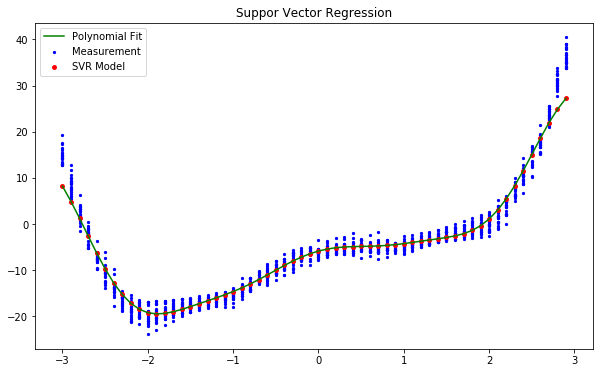

In [185]:
plt.rcParams['figure.figsize'] = (10, 6)

modelSVR = svm.SVR(kernel = 'rbf')
modelSVR.fit(X1D, Y.reshape(len(Y[0, :]) * sweeps)) # fit the SVR with the training data
y_svr = modelSVR.predict(x.reshape(-1, 1)) # output of the SVR model

p = np.polyfit(x, y_svr, 20) # compute the polynomial fit
y_svr_poly = np.polyval(p, x) # output of the polynomial aproximation

plt.scatter(X1D, Y1D, s = 5, c = 'b', label = 'Measurement')
plt.scatter(x, y_svr, s = 15, c = 'r', label = 'SVR Model')
plt.plot(x, y_svr_poly, color = 'green', label = 'Polynomial Fit')
plt.title('Suppor Vector Regression')
#plt.xlim([-2.5, 2.5])
#plt.ylim([-30,  10 ])
plt.legend()
plt.savefig('model_fit.png')
plt.savefig('model_fit.pdf')
plt.show()

plt.rcParams['figure.figsize'] = (6, 4)

The secret formula has the form of
$$f(x) = \sum_{i = 0}^{N}p_{i}x^{N-i},$$
where $p_{i}$ are the values of the polynomial fit and $ N = 20 $.

In [175]:
print(p)

[ -5.20371223e-07  -2.14334732e-07   2.49264829e-05   9.08149239e-06
  -5.03301658e-04  -1.56492098e-04   5.36609919e-03   1.27351231e-03
  -2.89912527e-02  -2.62828719e-03   2.97099567e-02  -3.57328667e-02
   5.30494872e-01   2.85682980e-01  -2.88483962e+00  -7.74351987e-01
   6.49558952e+00   7.03112154e-01  -7.72630043e+00   5.01392254e+00
  -5.84661139e+00]


The formula is implemented in the `secretformula` module. The last step is to test with new data.

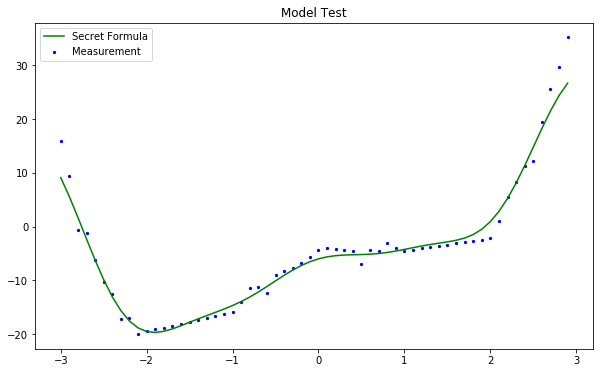

In [184]:
import secretformula

test_y = get_data(lim = lim, step = step)
test_y_poly = secretformula.f(x)

plt.rcParams['figure.figsize'] = (10, 6)

plt.scatter(x, test_y, s = 5, c = 'b', label = 'Measurement')
plt.plot(x, test_y_poly, 'g', label = 'Secret Formula')
plt.title('Model Test')
plt.legend()
plt.savefig('model_test.png')
plt.savefig('model_test.pdf')
plt.show()

plt.rcParams['figure.figsize'] = (6, 4)